# Проверка гипотезы в Python

- Автор: Юлия прохорова
- Дата: 29.05.2025

**Цели и задачи проекта**

Сравнить пользователей из Санкт-Петербурга и Москвы сервиса Яндекс Книги. Проверить гипотезу: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении по сравнению с пользователями из Москвы. 

**Описание данных**

Данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`:
- `city` - город пользователя;
- `puid` - идентификатор пользователя;
- `hours` - общее количество часов активности


**Содержимое проекта**

- 1. Загрузка данных и знакомство с ними
- 2. Проверка гипотезы в Python
- 3. Выводы 

## Загрузка данных и знакомство с ними

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import numpy as np
import statsmodels.stats.power as smp
import statsmodels.stats.proportion as smprop

In [2]:
# Загрузим исследуемый датасет
df = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')

In [3]:
# Познакомимся с данными загруженного датасета
df

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434
...,...,...,...,...
8779,8779,Санкт-Петербург,1130000028554332,4.107774
8780,8780,Санкт-Петербург,1130000030307246,45.069222
8781,8781,Санкт-Петербург,1130000038726322,0.211944
8782,8782,Санкт-Петербург,1130000047892100,4.311841


In [4]:
# Познакомимся с данными загруженного датасета
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [5]:
# Удалим не нужный столбец Unnamed: 0
df.drop(columns=['Unnamed: 0'])

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434
...,...,...,...
8779,Санкт-Петербург,1130000028554332,4.107774
8780,Санкт-Петербург,1130000030307246,45.069222
8781,Санкт-Петербург,1130000038726322,0.211944
8782,Санкт-Петербург,1130000047892100,4.311841


In [6]:
# Проверка дубликатов
df['puid'].duplicated().sum()

244

In [7]:
# Удалим дубликаты
df=df.drop_duplicates(subset=['puid'], keep='first')

In [8]:
# Проверим удаление дубликатов
df['puid'].duplicated().sum()

0

## Проверка гипотезы в Python

Гипотеза: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуем статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками.

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

Рассмотрим размеры групп и среднее время активности в разрезе исследуемых городов.

In [9]:
result = df.groupby('city').agg(
    unique_puid_count=('puid', 'nunique'), 
    average_hours=('hours', 'mean')        
).reset_index()
result

,city,unique_puid_count,average_hours
0,Москва,6234,10.881092
1,Санкт-Петербург,2306,11.264433


Проверим распределение данных активности пользователей.

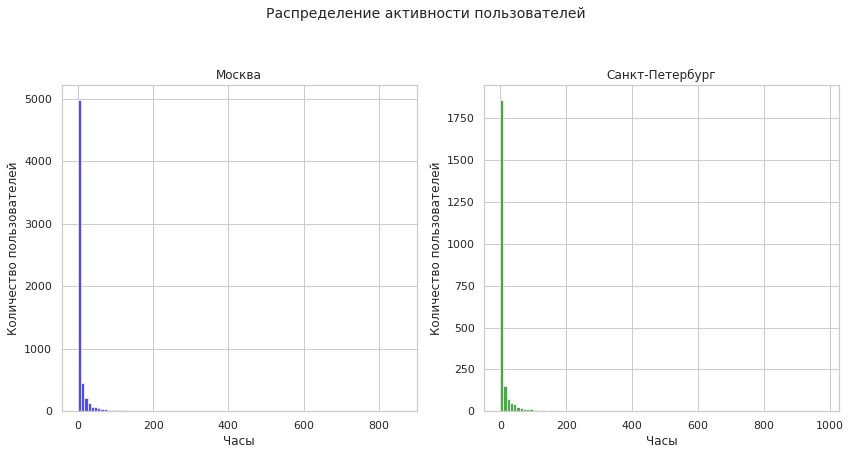

In [28]:
# Фильтрация данных по городам
moscow_data = df[df['city'] == 'Москва']
spb_data = df[df['city'] == 'Санкт-Петербург']

plt.figure(figsize=(12, 6))
plt.suptitle('Распределение активности пользователей', fontsize=14, y=1.05)  # Общий заголовок

plt.subplot(1, 2, 1)
plt.hist(moscow_data['hours'], bins=100, color='blue', alpha=0.7)
plt.title('Москва')
plt.xlabel('Часы')
plt.ylabel('Количество пользователей')  # Подпись оси Y

plt.subplot(1, 2, 2)
plt.hist(spb_data['hours'], bins=100, color='green', alpha=0.7)
plt.title('Санкт-Петербург')
plt.xlabel('Часы')
plt.ylabel('Количество пользователей')  # Подпись оси Y

plt.tight_layout()  # Для лучшего расположения элементов
plt.show()

In [11]:
# Фильтрация данных по городам
moscow_stats = df[df['city'] == 'Москва']['hours'].describe()
spb_stats = df[df['city'] == 'Санкт-Петербург']['hours'].describe()

# Добавляем 95-й процентиль
moscow_stats['95%'] = df[df['city'] == 'Москва']['hours'].quantile(0.95)
spb_stats['95%'] = df[df['city'] == 'Санкт-Петербург']['hours'].quantile(0.95)

# Объединение в одну таблицу для удобства
stats_comparison = pd.DataFrame({
    'Москва': moscow_stats,
    'Санкт-Петербург': spb_stats
})

print(stats_comparison)

            Москва  Санкт-Петербург
count  6234.000000      2306.000000
mean     10.881092        11.264433
std      36.851683        39.831755
min       0.000018         0.000025
25%       0.059903         0.060173
50%       0.924498         0.875355
75%       5.939972         6.138424
max     857.209373       978.764775
95%      54.871469        56.545642


Согласно гистограммам и основным статистическим показателям, данные об активности содержат выбросы. Построим гистограммы активности пользователей содержащих данные меньше 95 процентиля.

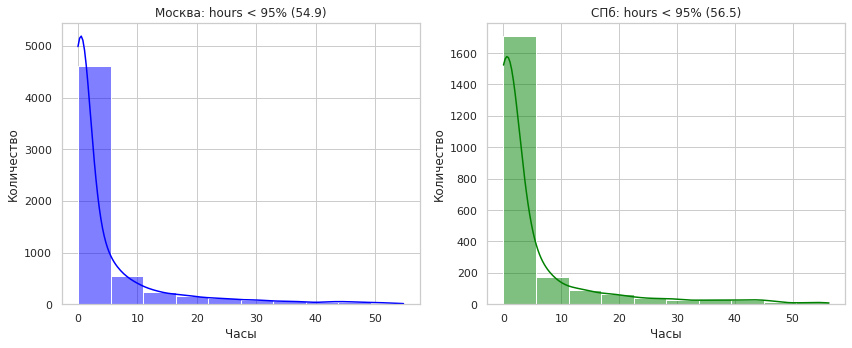

In [12]:
# Фильтрация данных по городам
moscow_data = df[df['city'] == 'Москва']
spb_data = df[df['city'] == 'Санкт-Петербург']

# Вычисление 95-го процентиля для каждого города
moscow_95 = moscow_data['hours'].quantile(0.95)
spb_95 = spb_data['hours'].quantile(0.95)

# Отбор значений ниже 95-го процентиля
moscow_top_5 = moscow_data[moscow_data['hours'] < moscow_95]
spb_top_5 = spb_data[spb_data['hours'] < spb_95]

# Настройка стиля
sns.set(style="whitegrid", palette="pastel")

# Создание гистограмм
plt.figure(figsize=(12, 5))

# Гистограмма для Москвы
plt.subplot(1, 2, 1)
sns.histplot(moscow_top_5['hours'], bins=10, color='blue', kde=True)
plt.title(f'Москва: hours < 95% ({moscow_95:.1f})')
plt.xlabel('Часы')
plt.ylabel('Количество')

# Гистограмма для Санкт-Петербурга
plt.subplot(1, 2, 2)
sns.histplot(spb_top_5['hours'], bins=10, color='green', kde=True)
plt.title(f'СПб: hours < 95% ({spb_95:.1f})')
plt.xlabel('Часы')
plt.ylabel('Количество')

plt.tight_layout()
plt.show()

Для проверки гипотезы будем использовать двухвыборочный t-тест Уэлча, т.к.:
- Целевая метрика: hours (количество часов) — непрерывная числовая переменная,
- Две независимые выборки: пользователи из Москвы и Санкт-Петербурга.
- Данные распределены нормально;
- Выборки отличны по размеру.

In [13]:
# Разделяем данные на две группы
msk_hours = df[df['city'] == 'Москва']['hours']
spb_hours = df[df['city'] == 'Санкт-Петербург']['hours']

# Уровень значимости
alpha = 0.05

# Проводим t-тест
results = st.ttest_ind(
    msk_hours,
    spb_hours,
    alternative='greater',
    equal_var=False
)

print('p-значение:', results.pvalue)

# Интерпретация
if results.pvalue < alpha:
    print('✅ Отвергаем нулевую гипотезу: пользователи СПб активнее!')
else:
    print('❌ Не получилось отвергнуть нулевую гипотезу: разницы нет.')

p-значение: 0.6564291881233686
❌ Не получилось отвергнуть нулевую гипотезу: разницы нет.


## Выводы

**Тип теста:**
- выбран односторонний t-тест Уэлча для двух независимых выборок (ttest_ind);
- уровень статистической значимости - 0.05.

**Результаты теста:**
- p-value: 0.66.

**Выводы:**
- Поскольку p-value > α (0.66 > 0.05), нет оснований отвергнуть нулевую гипотезу.
- Статистически значимых различий в среднем времени активности между пользователями Москвы и Санкт-Петербурга не обнаружено.

**Возможные причины полученных результатов:**
- 1. Пользователи из обоих городов могут иметь схожие модели поведения в приложении (например, одинаковую вовлеченность в чтение).
- 2. Возможное влияние выбросов: наличие аномально высоких значений (например, у нескольких пользователей) могло "перетянуть" среднее, скрыв различия.
